In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Pelabelan Dataset**

Karena dataset belum memiliki label sentimen, maka pertama kita perlu melakukan sentimen analisis dengan bantuan SentimentIntensityAnalyzer dari library NLTK.

In [58]:
import re
import string
import nltk
import matplotlib.pyplot as plt
plt.rc('figure',figsize=(17,13))
import seaborn as sns
import pandas as pd
import numpy as np
sns.set_style('darkgrid')
import plotly.express as ex
from plotly.subplots import make_subplots
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from wordcloud import WordCloud,STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import datetime
import itertools

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [59]:
filepath = '/content/drive/MyDrive/Scrapping Web Tripadvisor/cleaned_data/all.csv'
df = pd.read_csv(filepath)

In [60]:
df.head()

,place,location,content,rating_num,dates
0,kuta,Waterbom_Bali,This was unexpectedly so much fun and a really...,5,2021-12-30
1,kuta,Waterbom_Bali,An enjoyable day with my family. Booked the ti...,5,2021-12-30
2,kuta,Waterbom_Bali,A place of fun and joy! We really high recomme...,4,2021-12-14
3,kuta,Waterbom_Bali,This is the place to make memorable experience...,5,2021-12-14
4,kuta,Waterbom_Bali,We came here multiple times but only now have ...,5,2021-12-05


In [61]:
df.shape

(2253, 5)

In [62]:
df.isnull().sum()

place         0
location      0
content       0
rating_num    0
dates         0
dtype: int64

In [63]:
df['place'].value_counts()

nusa_dua         477
ubud             442
kuta             307
legian           257
canggu           212
seminyak         196
sanur            161
tanjung_benoa     92
jimbaran          89
payangan          20
Name: place, dtype: int64

In [64]:
df['rating_num'].value_counts()

5    1436
4     439
3     175
1     127
2      76
Name: rating_num, dtype: int64

In [65]:
li= df.place.unique()

In [66]:
for i in li:
  print(i, ' : ', df[df['place']==i]['location'].value_counts().count())

kuta  :  26
sanur  :  20
canggu  :  17
jimbaran  :  10
legian  :  15
nusa_dua  :  20
tanjung_benoa  :  14
payangan  :  3
ubud  :  28
seminyak  :  13


In [67]:
df_clean = df.copy()

## **Preprocessing**

Karena data dari Twitter belum memiliki format kebahasaan yang sama maka perlu dilakukan preprocessing. Preprocessing yang dilakukan ada beberapa tahap, yaitu
1. Case folding
2. Menghapus tanda baca
3. Menghapus karakter tunggal dan spasi berlebih
4. Menghapus stopwords
5. Menghapus emotikon

In [68]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def preprocessing(df):
  df = df.str.lower()
  df = df.apply(lambda x:re.sub(r"http\S+", "", x))
  punctuation_removal = string.punctuation
  df = df.apply(lambda text: text.translate(str.maketrans('', '', punctuation_removal)))
  df = df.replace(["“", "”"], "")
  # Single character and double space removal
  df = df.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))
  df = df.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))
  # Stopword Removal
  ", ".join(stopwords.words('english'))
  STOPWORDS = set(stopwords.words('english'))
  df = df.apply(lambda text: " ".join([word for word in str(text).split() if word not in STOPWORDS]))
  df = df.apply(str)
  df = df.apply(remove_emoji)
  return df

In [69]:
df_clean['content'] = preprocessing(df_clean['content'])
df_clean['content']

0       unexpectedly much fun andreally great way spen...
1       enjoyable day family booked tickets online wat...
2       place fun joy really high recommend visit wate...
3       place make memorable experiencethere exciting ...
4       came multiple times havehad chance leave somet...
                              ...                        
2248    spa treatment excellent affordable pricecan sa...
2249    reflexology good therapists well trained profe...
2250    mom “ibu made” great experience spa best balin...
2251    best massage experienceever already implemente...
2252    im happy experience zanti begining end already...
Name: content, Length: 2253, dtype: object

Kata yang paling sering muncul dalam dataset

In [70]:
from collections import Counter
cnt = Counter()
for text in df_clean['content'].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(10)

[('beach', 700),
 ('place', 605),
 ('massage', 532),
 ('good', 499),
 ('bali', 460),
 ('great', 413),
 ('time', 368),
 ('one', 353),
 ('nice', 352),
 ('experience', 349)]

## **Sentimen Analisis**

Setelah dataset telah bersih, maka kita dapat melakukan sentimen analisis dari teks content dengan menggunakan SIA().

In [71]:
# Sentiment analysis
sid = SIA()
df_clean['sentiments'] = df_clean["content"].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',str(x).lower()))))
df_clean['Positive Sentiment'] = df_clean['sentiments'].apply(lambda x: x['pos']+1*(10**-6)) 
df_clean['Neutral Sentiment'] = df_clean['sentiments'].apply(lambda x: x['neu']+1*(10**-6))
df_clean['Negative Sentiment'] = df_clean['sentiments'].apply(lambda x: x['neg']+1*(10**-6))
df_clean['Compound Sentiment'] = df_clean['sentiments'].apply(lambda x: x['compound']+1*(10**-6)) 
df_clean.head()

,place,location,content,rating_num,dates,sentiments,Positive Sentiment,Neutral Sentiment,Negative Sentiment,Compound Sentiment
0,kuta,Waterbom_Bali,unexpectedly much fun andreally great way spen...,5,2021-12-30,"{'neg': 0.0, 'neu': 0.717, 'pos': 0.283, 'comp...",0.283001,0.717001,0.000001,0.858801
1,kuta,Waterbom_Bali,enjoyable day family booked tickets online wat...,5,2021-12-30,"{'neg': 0.0, 'neu': 0.498, 'pos': 0.502, 'comp...",0.502001,0.498001,0.000001,0.952801
2,kuta,Waterbom_Bali,place fun joy really high recommend visit wate...,4,2021-12-14,"{'neg': 0.0, 'neu': 0.393, 'pos': 0.607, 'comp...",0.607001,0.393001,0.000001,0.931001
3,kuta,Waterbom_Bali,place make memorable experiencethere exciting ...,5,2021-12-14,"{'neg': 0.0, 'neu': 0.521, 'pos': 0.479, 'comp...",0.479001,0.521001,0.000001,0.877901
4,kuta,Waterbom_Bali,came multiple times havehad chance leave somet...,5,2021-12-05,"{'neg': 0.021, 'neu': 0.576, 'pos': 0.403, 'co...",0.403001,0.576001,0.021001,0.967801


## **Pelabelan**

Setelah mengetahui nilai sentimen tiap content, maka kita dapat memberi label (1 : positif, 2 : negatif, 0 : netral) pada dataset.
1. Jika compound sentimen >= 0.05 maka bernilai 1
2. Jika compound sentimen <= - 0.05 maka bernilai 2
3. Selain itu bernilai 0

In [72]:
senti = []
for index, row in df_clean.iterrows():
  if (row['Compound Sentiment']>=0.05):
    senti.append(1)
  elif(row['Compound Sentiment']<=-0.05):
    senti.append(2)
  else:
    senti.append(0)

In [73]:
len(df_clean)

2253

In [74]:
df_clean['label'] = senti
df_clean

,place,location,content,rating_num,dates,sentiments,Positive Sentiment,Neutral Sentiment,Negative Sentiment,Compound Sentiment,label
0,kuta,Waterbom_Bali,unexpectedly much fun andreally great way spen...,5,2021-12-30,"{'neg': 0.0, 'neu': 0.717, 'pos': 0.283, 'comp...",0.283001,0.717001,0.000001,0.858801,1
1,kuta,Waterbom_Bali,enjoyable day family booked tickets online wat...,5,2021-12-30,"{'neg': 0.0, 'neu': 0.498, 'pos': 0.502, 'comp...",0.502001,0.498001,0.000001,0.952801,1
2,kuta,Waterbom_Bali,place fun joy really high recommend visit wate...,4,2021-12-14,"{'neg': 0.0, 'neu': 0.393, 'pos': 0.607, 'comp...",0.607001,0.393001,0.000001,0.931001,1
3,kuta,Waterbom_Bali,place make memorable experiencethere exciting ...,5,2021-12-14,"{'neg': 0.0, 'neu': 0.521, 'pos': 0.479, 'comp...",0.479001,0.521001,0.000001,0.877901,1
4,kuta,Waterbom_Bali,came multiple times havehad chance leave somet...,5,2021-12-05,"{'neg': 0.021, 'neu': 0.576, 'pos': 0.403, 'co...",0.403001,0.576001,0.021001,0.967801,1
...,...,...,...,...,...,...,...,...,...,...,...
2248,seminyak,Zanti_The_Retreat,spa treatment excellent affordable pricecan sa...,5,2020-08-06,"{'neg': 0.0, 'neu': 0.696, 'pos': 0.304, 'comp...",0.304001,0.696001,0.000001,0.888501,1
2249,seminyak,Zanti_The_Retreat,reflexology good therapists well trained profe...,5,2020-08-06,"{'neg': 0.0, 'neu': 0.792, 'pos': 0.208, 'comp...",0.208001,0.792001,0.000001,0.859101,1
2250,seminyak,Zanti_The_Retreat,mom “ibu made” great experience spa best balin...,5,2020-08-01,"{'neg': 0.0, 'neu': 0.558, 'pos': 0.442, 'comp...",0.442001,0.558001,0.000001,0.959501,1
2251,seminyak,Zanti_The_Retreat,best massage experienceever already implemente...,5,2020-07-08,"{'neg': 0.0, 'neu': 0.49, 'pos': 0.51, 'compou...",0.510001,0.490001,0.000001,0.956501,1


In [75]:
df_clean.to_csv('/content/drive/MyDrive/Scrapping Web Tripadvisor/cleaned_labeled_data/df_labeled.csv', index=False)

# **Klasifikasi**

Setelah data telah bersih dan memiliki label maka selanjutnya kita dapat melakukan proses klasifikasi

In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import time
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Sequential
from keras.layers import Dense

## **Data Preparation**

In [77]:
df = pd.read_csv('/content/drive/MyDrive/Scrapping Web Tripadvisor/cleaned_labeled_data/df_labeled.csv')
df

,place,location,content,rating_num,dates,sentiments,Positive Sentiment,Neutral Sentiment,Negative Sentiment,Compound Sentiment,label
0,kuta,Waterbom_Bali,unexpectedly much fun andreally great way spen...,5,2021-12-30,"{'neg': 0.0, 'neu': 0.717, 'pos': 0.283, 'comp...",0.283001,0.717001,0.000001,0.858801,1
1,kuta,Waterbom_Bali,enjoyable day family booked tickets online wat...,5,2021-12-30,"{'neg': 0.0, 'neu': 0.498, 'pos': 0.502, 'comp...",0.502001,0.498001,0.000001,0.952801,1
2,kuta,Waterbom_Bali,place fun joy really high recommend visit wate...,4,2021-12-14,"{'neg': 0.0, 'neu': 0.393, 'pos': 0.607, 'comp...",0.607001,0.393001,0.000001,0.931001,1
3,kuta,Waterbom_Bali,place make memorable experiencethere exciting ...,5,2021-12-14,"{'neg': 0.0, 'neu': 0.521, 'pos': 0.479, 'comp...",0.479001,0.521001,0.000001,0.877901,1
4,kuta,Waterbom_Bali,came multiple times havehad chance leave somet...,5,2021-12-05,"{'neg': 0.021, 'neu': 0.576, 'pos': 0.403, 'co...",0.403001,0.576001,0.021001,0.967801,1
...,...,...,...,...,...,...,...,...,...,...,...
2248,seminyak,Zanti_The_Retreat,spa treatment excellent affordable pricecan sa...,5,2020-08-06,"{'neg': 0.0, 'neu': 0.696, 'pos': 0.304, 'comp...",0.304001,0.696001,0.000001,0.888501,1
2249,seminyak,Zanti_The_Retreat,reflexology good therapists well trained profe...,5,2020-08-06,"{'neg': 0.0, 'neu': 0.792, 'pos': 0.208, 'comp...",0.208001,0.792001,0.000001,0.859101,1
2250,seminyak,Zanti_The_Retreat,mom “ibu made” great experience spa best balin...,5,2020-08-01,"{'neg': 0.0, 'neu': 0.558, 'pos': 0.442, 'comp...",0.442001,0.558001,0.000001,0.959501,1
2251,seminyak,Zanti_The_Retreat,best massage experienceever already implemente...,5,2020-07-08,"{'neg': 0.0, 'neu': 0.49, 'pos': 0.51, 'compou...",0.510001,0.490001,0.000001,0.956501,1


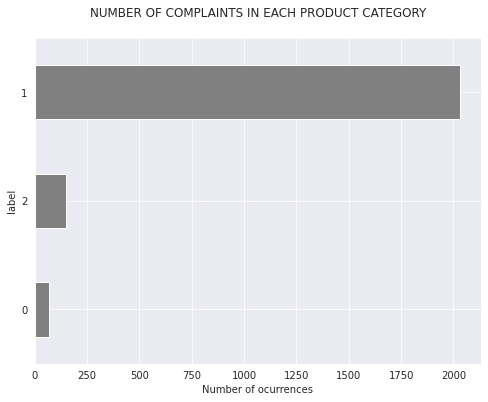

In [78]:
fig = plt.figure(figsize=(8,6))
colors = ['grey','grey', 'grey','darkblue','darkblue','darkblue']
df.groupby('label').content.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF COMPLAINTS IN EACH PRODUCT CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

In [79]:
df['label'].value_counts()

1    2030
2     152
0      71
Name: label, dtype: int64

In [80]:
df['rating_num'].value_counts()

5    1436
4     439
3     175
1     127
2      76
Name: rating_num, dtype: int64

Dilakukan pembagian dataset menjadi data training dan data testing menggunakan train_test_split. Perbandingan data latih dan data uji adalah 80:20.

In [83]:
X = df['content']
y = df['label']

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
df_train = pd.DataFrame()
df_train['content'] = X_train
df_train['hasil_sentimen'] = y_train

df_test = pd.DataFrame()
df_test['content'] = X_test
df_test['hasil_sentimen'] = y_test

df_train.to_csv('/content/drive/MyDrive/Tugas/FP-KK/Dataset/df_train.csv', index=False)
df_test.to_csv('/content/drive/MyDrive/Tugas/FP-KK/Dataset/df_test.csv', index=False)

In [ ]:
df_train

,tweet,hasil_sentimen
6753,done second dose sinovac thanks god,1
3018,excited muschealth rolling pfizerbiontech covi...,1
5224,happy friday covaxin ocgn,1
7934,potus help stay calm waiting vaccinatedlistene...,1
9264,wionews buy covaxin india safe effective,1
...,...,...
5734,great thread covidvaccine covid19 covaxin,1
5191,thankful amp grateful roadtozero sinovac vacci...,1
5390,second dose moderna thankful,1
860,government saying infew weeks time cannot mixe...,0


## **Feature Extraction**

Setelah data telah dipreprocessing dan split, langkah selanjutnya adalah melakukan feature extraction. Metode yang digunakan adalah TFIDF.

In [84]:
# membuat vektor dari fitur
vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
train_vectors = vectorizer.fit_transform(X)

In [85]:
train_vectors.shape

(2253, 1990)

## **Gabungan Beberapa Model**

In [86]:
models = [
    svm.SVC(C=1, degree=1, gamma='scale', kernel='linear'),
    MLPClassifier(hidden_layer_sizes=(256,128,64,32),activation="relu",random_state=1),
    DecisionTreeClassifier(max_depth=20, min_samples_leaf= 5, criterion = "gini"),
    KNeighborsClassifier(leaf_size=1, n_neighbors=1, p=2),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, train_vectors, y, scoring='accuracy', cv=CV)
  f1 = cross_val_score(model, train_vectors, y, scoring='f1_weighted', cv=CV)
  i = 0
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy, f1[i]))
    i=i+1
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy', 'f1'])

In [87]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()
f1_score = cv_df.groupby('model_name').f1.mean()

acc = pd.concat([mean_accuracy, std_accuracy, f1_score], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation', 'f1 score']
acc

,Mean Accuracy,Standard deviation,f1 score
model_name,,,
DecisionTreeClassifier,0.874402,0.023635,0.858264
KNeighborsClassifier,0.826472,0.063296,0.831271
MLPClassifier,0.897033,0.021896,0.874306
SVC,0.898807,0.011639,0.857852


## **Hyperparameter Tuning SVC**

In [90]:
param_grid = { 'C':[0.1,1,100,1000],'kernel':['rbf','poly','sigmoid','linear'],
              'degree':[1,2,3,4,5,6], 
              'gamma' : ['scale', 'auto']}
grid = GridSearchCV(svm.SVC(),param_grid)
grid.fit(train_vectors,y)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 100, 1000], 'degree': [1, 2, 3, 4, 5, 6],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['rbf', 'poly', 'sigmoid', 'linear']})

In [93]:
print(grid.best_params_)

{'C': 100, 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}


In [94]:
from sklearn.model_selection import cross_val_score
clf = svm.SVC(C=1, degree=1, gamma='scale', kernel='rbf')
scores = cross_val_score(clf, train_vectors,y, cv=5)
scores

array([0.89800443, 0.90022173, 0.90022173, 0.90222222, 0.90222222])